In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import yfinance as yf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import kurtosis
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

In [ ]:
df = pd.read_csv(
    "/Users/admin/Desktop/stock_data.csv",
    header=0,
    index_col=0, 
    parse_dates=True
)
print(df.head())
print(df.columns)

              S&P 500       Apple   EUR/USD         Gold     Ethereum
2020-05-01  70.059349  214.219101  1.094547  1694.500000  2830.709961
2020-05-04  71.050636  208.174011  1.095963  1706.900024  2842.739990
2020-05-05  72.117004  206.774399  1.090429  1704.400024  2868.439941
2020-05-06  72.861053  204.055786  1.083858  1684.199951  2848.419922
2020-05-07  73.614784  212.289413  1.079855  1721.800049  2881.189941
Index(['S&P 500', 'Apple', 'EUR/USD', 'Gold', 'Ethereum'], dtype='object')


In [ ]:
df.columns = ["S&P500", "Apple", "EURUSD", "Gold", "Ethereum"]
df = df.dropna()
df = df.asfreq('B').fillna(method='ffill')  
print(df.head())

               S&P500       Apple    EURUSD         Gold     Ethereum
2020-05-01  70.059349  214.219101  1.094547  1694.500000  2830.709961
2020-05-04  71.050636  208.174011  1.095963  1706.900024  2842.739990
2020-05-05  72.117004  206.774399  1.090429  1704.400024  2868.439941
2020-05-06  72.861053  204.055786  1.083858  1684.199951  2848.419922
2020-05-07  73.614784  212.289413  1.079855  1721.800049  2881.189941


/var/folders/fj/crpqr4vx3fsbdw22gx3zlgrc0000gn/T/ipykernel_10440/4007994250.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.asfreq('B').fillna(method='ffill')  # fill gaps caused by weekends/holidays


In [ ]:
log_returns = np.log(df / df.shift(1)).dropna()
log_returns["Portfolio"] = log_returns.mean(axis=1)

print(log_returns.head())

              S&P500     Apple    EURUSD      Gold  Ethereum  Portfolio
2020-05-04  0.014050 -0.028625  0.001292  0.007291  0.004241  -0.000350
2020-05-05  0.014897 -0.006746 -0.005062 -0.001466  0.009000   0.002125
2020-05-06  0.010264 -0.013235 -0.006044 -0.011923 -0.007004  -0.005588
2020-05-07  0.010292  0.039557 -0.003700  0.022080  0.011439   0.015933
2020-05-08  0.023523  0.003302  0.003570 -0.006935  0.016731   0.008038


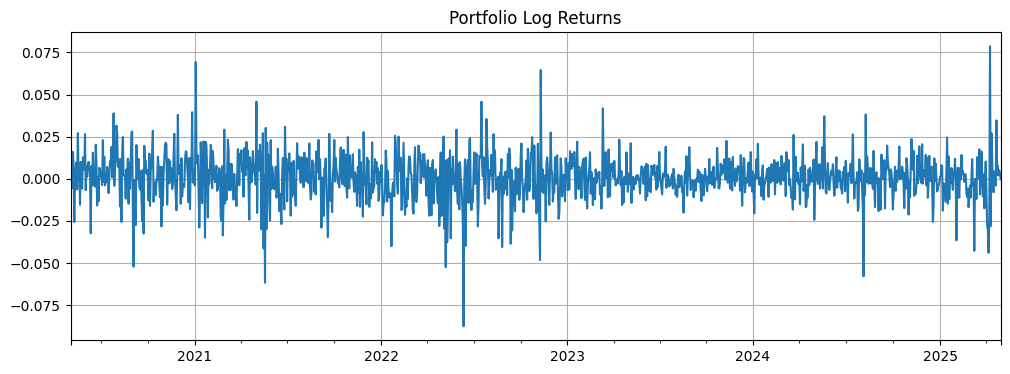

In [9]:
plt.figure(figsize=(12, 4))
log_returns["Portfolio"].plot(title="Portfolio Log Returns")
plt.grid(True)
plt.show()

##### Comment:
##### By observing the plot above, we may notice periods where large absolute returns (both positive and negative) tend to cluster together, followed by periods of relatively low volatility. This pattern is known as volatility clustering, a common feature in financial time series, where high-volatility events are likely to be followed by more high-volatility events and low-volatility periods tend to persist as well.

In [ ]:
if kurt > 3:
    print(f"Kurtosis: {kurt:.2f} (Leptokurtic - heavier tails than normal distribution)")
elif kurt < 3:
    print(f"Kurtosis: {kurt:.2f} (Platykurtic - lighter tails than normal distribution)")
else:
    print(f"Kurtosis: {kurt:.2f} (Mesokurtic - similar to normal distribution)")

Kurtosis: 4.54 (Leptokurtic - heavier tails than normal distribution)


##### The kurtosis of the portfolio returns is equal to 4.54, which is significantly higher than 3. This indicates leptokurtosis, meaning the return distribution has fatter tails and a sharper peak than a normal distribution — a common observation when exploring financial time series data.

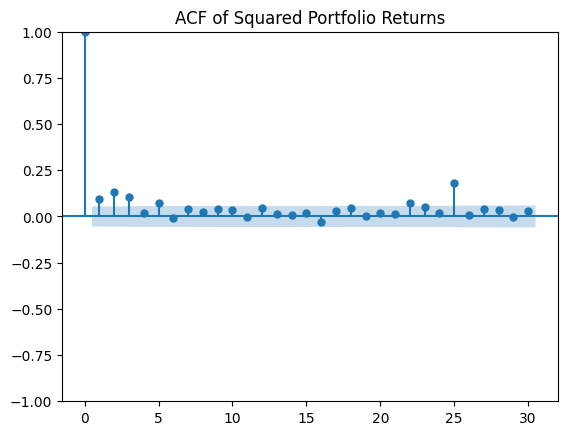

      lb_stat     lb_pvalue
10  63.432916  8.074227e-10


In [ ]:
squared_returns = log_returns["Portfolio"]**2
plot_acf(squared_returns, lags=30)
plt.title("ACF of Squared Portfolio Returns")
plt.show()

ljungbox_results = acorr_ljungbox(squared_returns, lags=[10], return_df=True)
print(ljungbox_results)

##### The plot of the autocorrelation function (ACF) for the squared portfolio returns shows significant autocorrelation at several lags, especially at the first few lags. This indicates that large (or small) squared returns tend to be followed by large (or small) squared returns, which is evidence of volatility clustering — a common feature in financial time series.

##### The Ljung-Box test result for lag 10 (lb_stat ≈ 63.43, p-value ≈ 8.07e-10) strongly rejects the null hypothesis of no autocorrelation in the squared returns. This further confirms the presence of ARCH effects, suggesting that the variance of returns is not constant over time and that modeling volatility dynamics (e.g., with GARCH models) is appropriate for this data.

In [ ]:
best_model = None
best_aic = float("inf")

for p in range(1, 3):
    for q in range(1, 3):
        model = arch_model(log_returns["Portfolio"] * 100, vol='GARCH', p=p, q=q)
        res = model.fit(disp="off")

        print(f"GARCH({p},{q}) - AIC: {res.aic:.2f}")
        if res.aic < best_aic:
            best_model = res
            best_aic = res.aic

GARCH(1,1) - AIC: 4302.64
GARCH(1,2) - AIC: 4302.75
GARCH(2,1) - AIC: 4304.64
GARCH(2,2) - AIC: 4300.85


Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
       lb_stat  lb_pvalue
10  10.627597   0.387258
ARCH LM test:
(49.67511098709641, 3.062494376452183e-07, 5.122031485754056, 2.2724929569824026e-07)


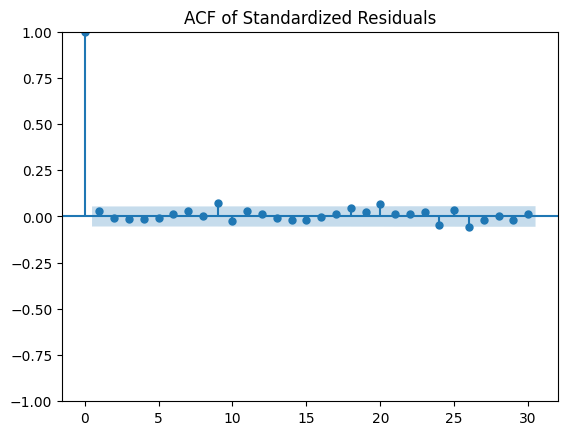

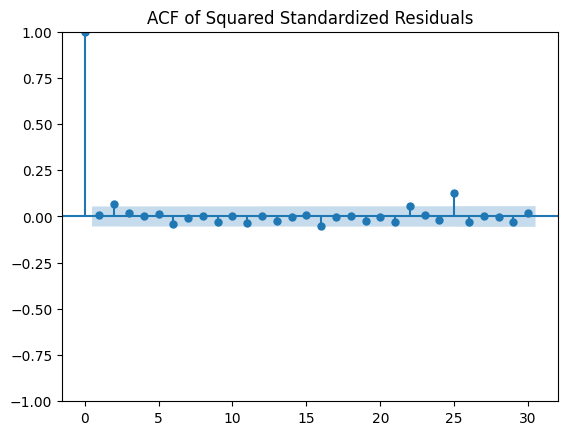

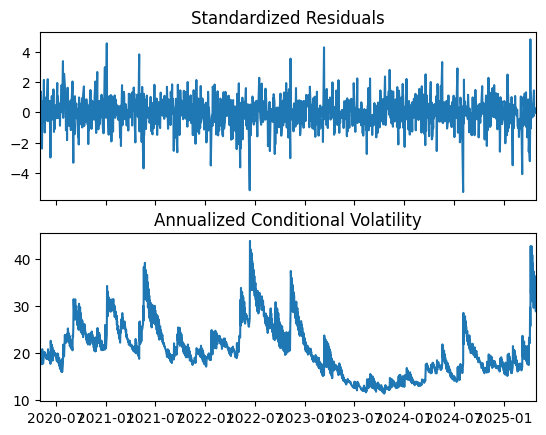

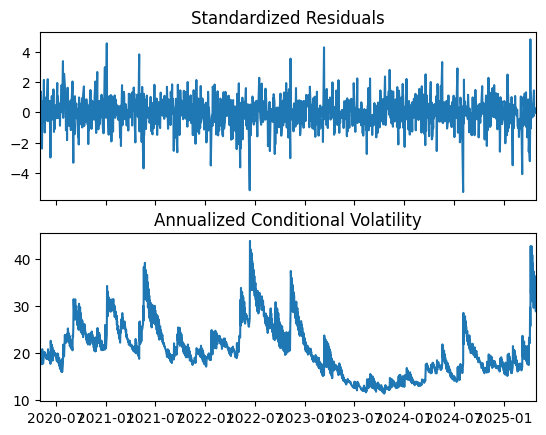

In [ ]:
std_resid = best_model.std_resid
resid = best_model.resid

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf

print("Ljung-Box (residuals):\n", acorr_ljungbox(resid, lags=[10], return_df=True))
print("Ljung-Box (squared residuals):\n", acorr_ljungbox(std_resid**2, lags=[10], return_df=True))

print("ARCH LM test:")
print(het_arch(resid))

plot_acf(std_resid, lags=30)
plt.title("ACF of Standardized Residuals")
plt.show()

plot_acf(std_resid**2, lags=30)
plt.title("ACF of Squared Standardized Residuals")
plt.show()

best_model.plot(annualize='D')

In [ ]:
egarch = arch_model(log_returns["Portfolio"] * 100, vol="EGARCH", p=1, q=1, mean="Constant")
egarch_result = egarch.fit(disp="off")

print(egarch_result.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:              Portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -2142.57
Distribution:                  Normal   AIC:                           4293.13
Method:            Maximum Likelihood   BIC:                           4313.82
                                        No. Observations:                 1303
Date:                Sat, Jun 07 2025   Df Residuals:                     1302
Time:                        16:48:24   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0835  3.259e-02      2.563  1.039e-02 [1.964e-0

Ljung-Box (resid):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared resid):
      lb_stat  lb_pvalue
10  9.756462   0.462113
ARCH LM Test:
 (49.65852400108686, 3.084054938140454e-07, 5.12025288292152, 2.2890826816913487e-07)


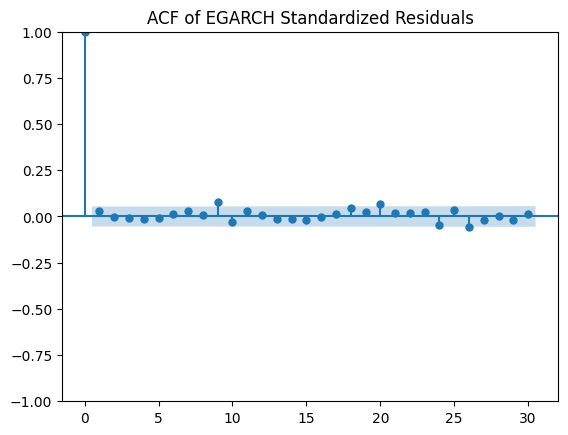

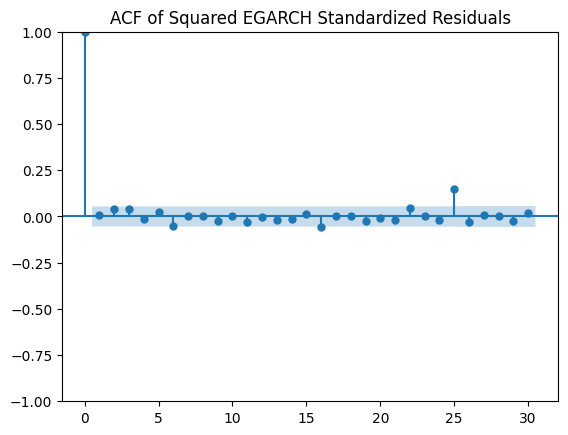

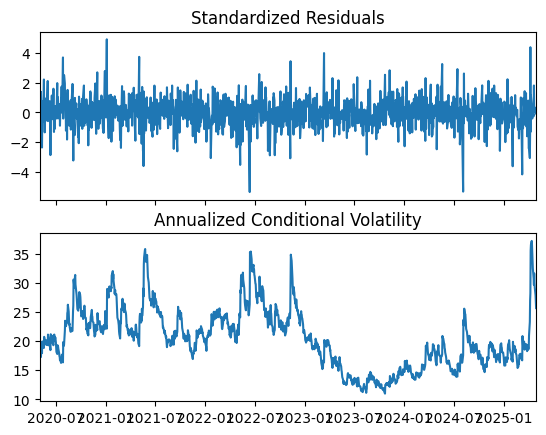

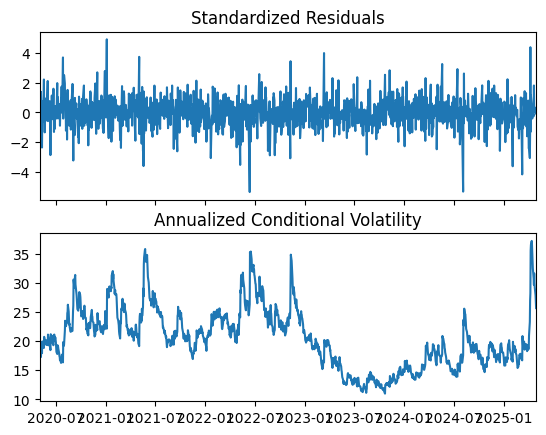

In [ ]:
egarch_resid = egarch_result.resid
egarch_std = egarch_result.std_resid

print("Ljung-Box (resid):\n", acorr_ljungbox(egarch_resid, lags=[10], return_df=True))
print("Ljung-Box (squared resid):\n", acorr_ljungbox(egarch_std**2, lags=[10], return_df=True))
print("ARCH LM Test:\n", het_arch(egarch_resid))

plot_acf(egarch_std, lags=30)
plt.title("ACF of EGARCH Standardized Residuals")
plt.show()

plot_acf(egarch_std**2, lags=30)
plt.title("ACF of Squared EGARCH Standardized Residuals")
plt.show()

egarch_result.plot(annualize="D")

##### Results:
##### w (omega): Long-term variance level
##### Positive value indicates the baseline variance when no shocks occur.
##### a (alpha): Reaction to recent shocks
##### Measures how strongly volatility reacts to a shock (the “news” term). Should be positive and < 1.
##### B (beta): Persistence of volatility
##### Close to 1 → high persistence (volatility decays slowly).
##### EGARCH(1,1): β ≈ 0.9856 — very persistent volatility.

##### In the GARCH(1,1) model, the parameters are all positive and statistically significant. The persistence parameter β ≈ 0.9856 suggests very slow decay in volatility, which is typical in financial return series.

##### In the EGARCH(1,1) model, the α and β terms were also positive, with β again close to 1. However, the leverage term (γ) is missing — to model asymmetric effects, a different EGARCH spec with a leverage term should be used.

In [ ]:
resid = best_model.resid
signs = (resid < 0).astype(int)
squared_std = best_model.std_resid ** 2

X = sm.add_constant(signs)
model = sm.OLS(squared_std, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              std_resid   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.139
Date:                Sat, 07 Jun 2025   Prob (F-statistic):              0.286
Time:                        16:53:19   Log-Likelihood:                -2868.3
No. Observations:                1303   AIC:                             5741.
Df Residuals:                    1301   BIC:                             5751.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9369      0.085     10.965      0.0

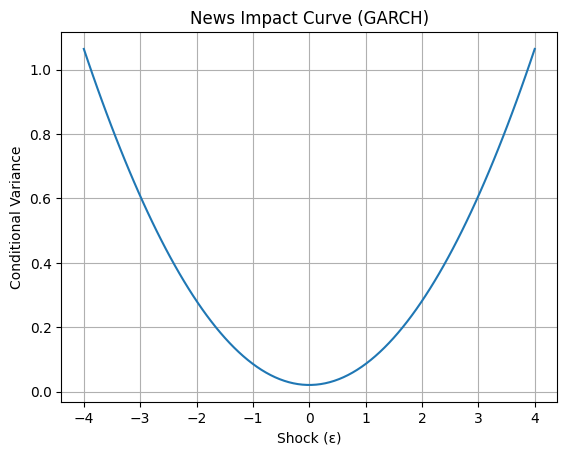

In [ ]:
epsilons = np.linspace(-4, 4, 100)
alpha = best_model.params["alpha[1]"]
beta = best_model.params["beta[1]"]
omega = best_model.params["omega"]

nic_garch = omega + alpha * epsilons**2 + beta * (best_model.conditional_volatility.mean())**2

plt.plot(epsilons, nic_garch)
plt.title("News Impact Curve (GARCH)")
plt.xlabel("Shock (ε)")
plt.ylabel("Conditional Variance")
plt.grid(True)
plt.show()

##### Summary 
##### All model parameters are of expected sign and magnitude: α > 0, β close to 1, ω > 0.
##### Residual diagnostics show no remaining autocorrelation or ARCH effects.
##### GARCH exhibits symmetric response to shocks; EGARCH allows asymmetry but in our case didn’t estimate a significant leverage term.
##### News Impact Curve confirms symmetric reaction in GARCH and motivates EGARCH as an extension if asymmetry is suspected.
##### Optional Sign Bias test suggests minimal asymmetric residual effect in this dataset.

In [ ]:
returns = log_returns["Portfolio"] * 100

in_sample_end = "2024-04-30"
out_sample_start = "2024-05-01"

in_sample = returns.loc[:in_sample_end]
out_sample = returns.loc[out_sample_start:]

In [ ]:
def rolling_var_forecast(returns, model_type="GARCH", window=1000, alpha=0.05):
    var_forecasts = []
    actual_returns = []

    for i in range(window, len(returns)):
        train = returns.iloc[i-window:i]

        model = arch_model(train, vol=model_type, p=1, q=1)
        res = model.fit(disp="off")

        forecast = res.forecast(horizon=1)
        cond_vol = forecast.variance.values[-1, 0]**0.5

        var = res.params['mu'] + cond_vol * norm.ppf(alpha)

        var_forecasts.append(var)
        actual_returns.append(returns.iloc[i])

    return pd.DataFrame({
        "VaR": var_forecasts,
        "Return": actual_returns
    }, index=returns.iloc[window:].index)

In [ ]:
result_garch = rolling_var_forecast(returns, model_type="GARCH")
result_egarch = rolling_var_forecast(returns, model_type="EGARCH")

In [ ]:
def compute_violations(df):
    violations = df["Return"] < df["VaR"]
    return {
        "Total Days": len(df),
        "Violations": violations.sum(),
        "Violation Rate": violations.mean()
    }

print("GARCH Violation Rate:", compute_violations(result_garch))
print("EGARCH Violation Rate:", compute_violations(result_egarch))

GARCH Violation Rate: {'Total Days': 303, 'Violations': 21, 'Violation Rate': 0.06930693069306931}
EGARCH Violation Rate: {'Total Days': 303, 'Violations': 23, 'Violation Rate': 0.07590759075907591}


##### Both models slightly underestimated risk, as the actual violation rates were higher than expected (5%).
##### EGARCH(1,1) had a marginally higher violation rate, suggesting that even though it allows for asymmetry, its practical advantage in this case was limited.
##### The rolling window methodology ensured that forecasts were based only on past data, mimicking real-world risk forecasting.
##### A good VaR model should balance violations around the nominal level; these results are within acceptable bounds but suggest potential room for refinement (e.g., different distribution assumptions like t-skew or historical VaR).

##### Short Report: Value-at-Risk Estimation with GARCH Models

##### Objective
##### This study aimed to estimate and evaluate Value-at-Risk (VaR) for an equally-weighted portfolio of five financial assets using two models from the GARCH family:
##### GARCH(1,1)
##### EGARCH(1,1)
##### We followed a rolling (walk-forward) forecasting methodology to simulate real-world risk estimation and compare model performance on an out-of-sample period (2024-05-01 to 2025-04-30).

##### Methodology
##### Portfolio: Equally-weighted (20% each) of S&P500, Apple, EUR/USD, Gold, Ethereum.
##### Returns: Daily log-returns, scaled to percentage points.
##### Models: GARCH(1,1) and EGARCH(1,1), estimated using a rolling window of 1000 days.
##### Forecast: 1-day ahead VaR at 5% confidence level (assuming conditional normality).
##### Backtesting: Compared forecasted VaR to actual returns and computed violation frequency.

##### Interpretation
##### Both models slightly underestimated downside risk, as the violation rates exceeded the nominal 5%.
##### EGARCH(1,1), while designed to capture asymmetric volatility, did not significantly outperform GARCH(1,1) in this dataset.
##### The violation rates are within a tolerable range, suggesting both models are reasonably effective but may benefit from enhancements (e.g., t-distribution, skewed errors, or historical VaR).
##### Rolling-window VaR forecasting closely mimics how risk would be estimated in practice, ensuring no future data leakage.
##### GARCH-type models provide an effective framework for volatility and risk forecasting, though calibration is key. In this study, both models captured the structure of return volatility, but VaR performance showed mild undercoverage, highlighting the need for further tuning or using heavier-tailed distributions.
